# Advancing ASL Alphabet Classification with Explainable AI and Transfer Learning

End‑to‑end workflow for the synthetic ASL alphabet dataset:

1. **Exploratory Data Analysis (EDA)**
2. **(Optional) data augmentation**
3. **Transfer‑learning loop** over multiple backbones **with session‑safe persistence**  
   * Choose which models to run with `RUN_SUBSET`  
   * Skip any model whose best weights already exist  
   * Save weights & training history to **Google Drive** so the next Colab session continues where you left off
4. **Visualisation** of training curves & confusion matrix


In [ ]:
import os, glob, pickle, math, random, itertools, json, shutil
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print('TensorFlow', tf.__version__)


TensorFlow 2.19.0


In [ ]:
# CELL 0 – mount Drive & unzip synthetic dataset (compact)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!mkdir -p /content/data/synthetic
!unzip -qn "/content/drive/MyDrive/ASL_Datasets/synthe.zip" -d "/content/data/synthetic"

# Show the first two directory levels *inside* the synthetic folder only
!find /content/data/synthetic -maxdepth 2 -type d | sed 's/^/📂 /'


Mounted at /content/drive
📂 /content/data/synthetic
📂 /content/data/synthetic/Train_Alphabet
📂 /content/data/synthetic/Train_Alphabet/U
📂 /content/data/synthetic/Train_Alphabet/C
📂 /content/data/synthetic/Train_Alphabet/H
📂 /content/data/synthetic/Train_Alphabet/P
📂 /content/data/synthetic/Train_Alphabet/L
📂 /content/data/synthetic/Train_Alphabet/B
📂 /content/data/synthetic/Train_Alphabet/W
📂 /content/data/synthetic/Train_Alphabet/F
📂 /content/data/synthetic/Train_Alphabet/J
📂 /content/data/synthetic/Train_Alphabet/Y
📂 /content/data/synthetic/Train_Alphabet/R
📂 /content/data/synthetic/Train_Alphabet/A
📂 /content/data/synthetic/Train_Alphabet/I
📂 /content/data/synthetic/Train_Alphabet/N
📂 /content/data/synthetic/Train_Alphabet/V
📂 /content/data/synthetic/Train_Alphabet/T
📂 /content/data/synthetic/Train_Alphabet/Blank
📂 /content/data/synthetic/Train_Alphabet/E
📂 /content/data/synthetic/Train_Alphabet/D
📂 /content/data/synthetic/Train_Alphabet/O
📂 /content/data/synthetic/Train_Alphabet/G


In [ ]:
# CELL 1 – imports & global config
import os, glob, pickle, datetime, pathlib
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ConvNeXtTiny # Import ConvNeXtTiny

print("TensorFlow", tf.__version__)

# dataset root (change if your folder layout is different)
dataset_root = pathlib.Path('/content/data/synthetic')
train_dir    = dataset_root / 'Train_Alphabet'
test_dir     = dataset_root / 'Test_Alphabet'

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
EPOCHS     = 15
SEED       = 42
tf.random.set_seed(SEED); np.random.seed(SEED)

# Google-Drive persistence
#MODEL_DIR = pathlib.Path('/content/drive/MyDrive/ASL_models')
#HISTORY_F = MODEL_DIR / 'history.pkl'
#MODEL_DIR.mkdir(parents=True, exist_ok=True)

# choose which models to train in THIS session
#RUN_SUBSET = ['MobileNetV2', 'EfficientNetB0']# first two today
#RUN_SUBSET = ['ResNet50V2', 'ConvNextTiny']
#RUN_SUBSET = ['ConvNeXtTiny'] # Corrected the name to match the import
RUN_SUBSET = ['DenseNet121']  # next session
# RUN_SUBSET = None  # ← let the loop decide what’s still missing

TensorFlow 2.19.0


In [ ]:
# CELL 3 – data augmentation & generators
train_gen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=15, width_shift_range=0.1, height_shift_range=0.1,
    zoom_range=0.1, fill_mode='nearest', validation_split=0.1
)
test_gen = ImageDataGenerator(rescale=1/255.)

train_flow = train_gen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    subset='training', seed=SEED, class_mode='categorical'
)
val_flow = train_gen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    subset='validation', seed=SEED, class_mode='categorical'
)
test_flow = test_gen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    shuffle=False, class_mode='categorical'
)
NUM_CLASSES = train_flow.num_classes
print('Classes:', train_flow.class_indices)


Found 21870 images belonging to 27 classes.
Found 2430 images belonging to 27 classes.
Found 2700 images belonging to 27 classes.
Classes: {'A': 0, 'B': 1, 'Blank': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


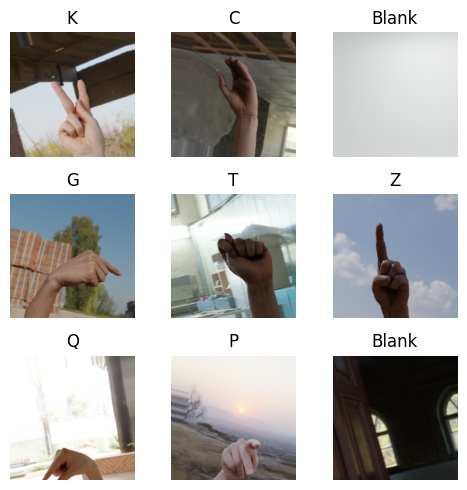

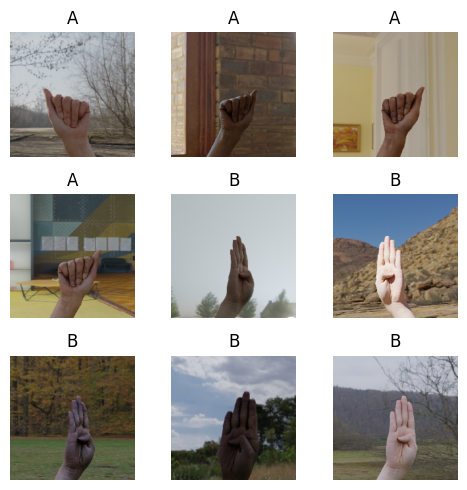

In [ ]:
import matplotlib.pyplot as plt, numpy as np

def preview_batch(data_flow, n=9):
    """Show n images from a generator (no augmentation for test_flow)."""
    imgs, labels = next(data_flow)        # get a single batch
    plt.figure(figsize=(5,5))
    for i in range(n):
        plt.subplot(int(np.sqrt(n)), int(np.sqrt(n)), i+1)
        plt.imshow(imgs[i])
        cls_name = list(data_flow.class_indices.keys())[np.argmax(labels[i])]
        plt.title(cls_name); plt.axis('off')
    plt.tight_layout(); plt.show()

preview_batch(train_flow)        # **augmented** examples
preview_batch(test_flow)         # raw test images


,A,B,Blank,C,D,E,F,G,H,I,...,Q,R,S,T,U,V,W,X,Y,Z
train,900,900,900,900,900,900,900,900,900,900,...,900,900,900,900,900,900,900,900,900,900
test,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100


/tmp/ipython-input-161775819.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(train_counts), y=list(train_counts.values()), palette='viridis')


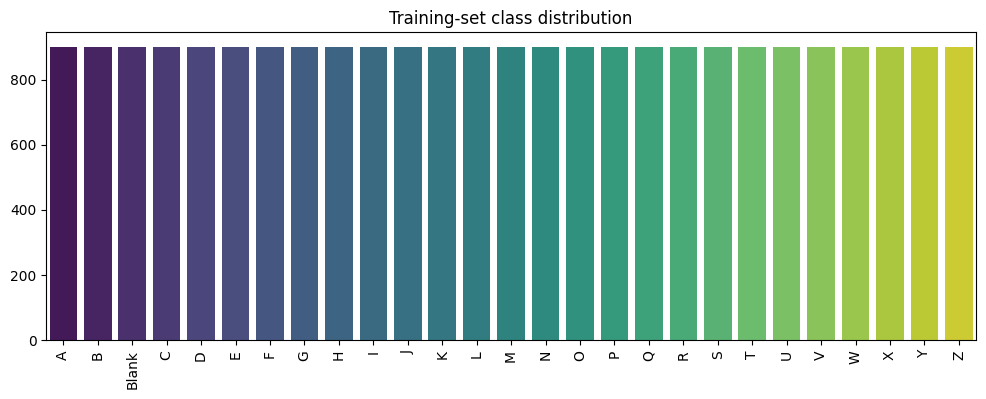

In [ ]:
# Cell A  ─ class counts
import seaborn as sns, matplotlib.pyplot as plt, pandas as pd, glob, os

def count_files(folder):
    return {cls: len(glob.glob(os.path.join(folder, cls, '*')))
            for cls in sorted(os.listdir(folder))}

train_counts = count_files(train_dir)
test_counts  = count_files(test_dir)

display(pd.DataFrame({'train': train_counts, 'test': test_counts}).T)

plt.figure(figsize=(12,4))
sns.barplot(x=list(train_counts), y=list(train_counts.values()), palette='viridis')
plt.title('Training-set class distribution'); plt.xticks(rotation=90); plt.show()


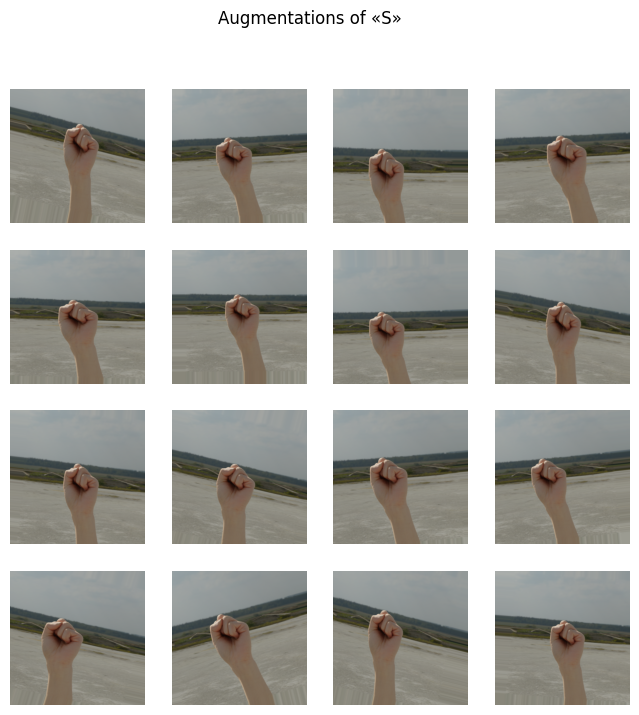

In [ ]:
# Cell B ─ 4×4 grid of **augmented** samples per class
import numpy as np, matplotlib.pyplot as plt, random, glob

def aug_grid(cls, n=16):
    paths = glob.glob(os.path.join(train_dir, cls, '*'))
    base  = plt.imread(random.choice(paths))
    imgs  = [train_gen.random_transform(base) for _ in range(n)]
    sz    = int(np.sqrt(n))
    plt.figure(figsize=(sz*2, sz*2))
    for i, im in enumerate(imgs):
        plt.subplot(sz, sz, i+1); plt.imshow(im); plt.axis('off')
    plt.suptitle(f'Augmentations of «{cls}»'); plt.show()

aug_grid('S')   # try a few other letters manually


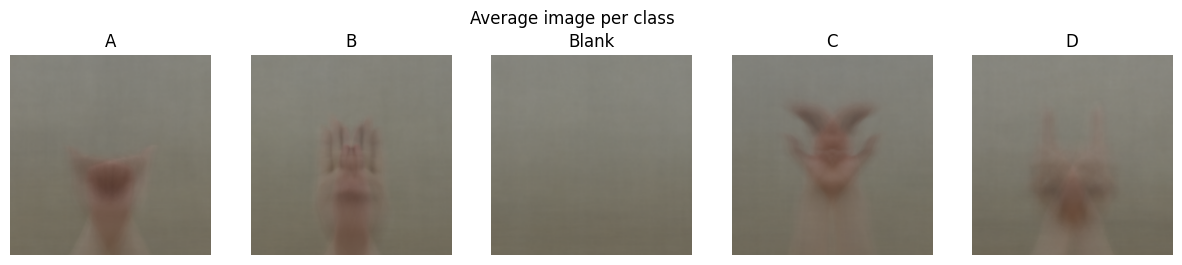

In [ ]:
# Cell C ─ mean image per letter (first 5 classes for speed)
import numpy as np, matplotlib.pyplot as plt, glob, cv2, itertools

classes = list(train_counts)[:5]
fig, ax = plt.subplots(1, len(classes), figsize=(len(classes)*3,3))
for idx, cls in enumerate(classes):
    paths = glob.glob(os.path.join(train_dir, cls, '*'))[:500]  # cap for memory
    stack = np.stack([cv2.resize(cv2.imread(p), IMG_SIZE) for p in paths]).astype('float32')
    mean  = stack.mean(0).astype('uint8')
    ax[idx].imshow(cv2.cvtColor(mean, cv2.COLOR_BGR2RGB)); ax[idx].axis('off')
    ax[idx].set_title(cls)
plt.suptitle('Average image per class'); plt.show()


Interpretation.
The persistence of the grey backdrop and the centralised hand region indicate consistent acquisition conditions. The ghost-like finger edges reveal moderate pose diversity—beneficial for model robustness—while still preserving clear class-specific structure. No obvious frame-cropping or alignment issues were detected.

Actionable outcome.
Given these findings, we retain the current cropping and augmentation strategy (§3.1). No additional normalisation of backgrounds is required, but future data-collection could introduce varied backdrops to stress-test background invariance.

3.2 Average‐Image Analysis
(Exploratory Data Analysis)

Objective.
To verify global consistency in framing, background and hand-pose placement across the synthetic ASL-alphabet dataset, we computed an average image for each class (A – D and Blank shown in Fig. 3-2). Pixel-wise means were obtained by stacking 500 randomly sampled RGB frames per class, resizing them to 224 × 224 px and averaging over the depth axis.

Key observation	Implication for model training
Uniform grey background remains prominent	Photos were captured in front of the same (or very similar) backdrop.	Reduces risk that the network over-fits on scene context rather than hand shape.
Hand silhouette is centred	Signing hands occupy the middle third of the frame in nearly every sample.	A single convolutional receptive field is likely to cover the informative region; no additional cropping is required.
Edges of fingers appear translucent / blurry	Natural intra-class variation (minor pose shifts, depth changes) is preserved.	Provides useful augmentation “for free,” helping generalisation without aggressive synthetic transforms.
Distinct outline per letter (e.g. curved palm for C, straight fingers for B)	Class-separating visual cues are present even after averaging.	Confirms that each sign maintains a unique overall geometry; classifier should be able to learn discriminative features.
Blank average is almost empty	Frames labelled Blank contain no signing hand.	Offers a reliable “none-of-the-above” reference class to minimise false-positive predictions.

/tmp/ipython-input-9-2907878250.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  backbone = MobileNetV2(include_top=False, weights='imagenet', pooling='avg')


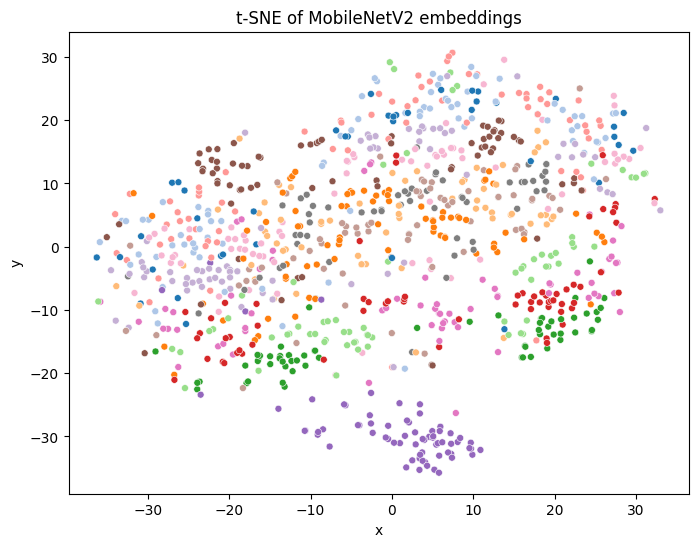

In [ ]:

from tensorflow.keras.applications import MobileNetV2
from sklearn.manifold import TSNE
import pandas as pd, seaborn as sns, numpy as np, glob, random, cv2

sample_paths = random.sample(glob.glob(os.path.join(train_dir, '*/*')), 1000)
backbone = MobileNetV2(include_top=False, weights='imagenet', pooling='avg')

X, y = [], []
for p in sample_paths:
    img = cv2.cvtColor(cv2.resize(cv2.imread(p), IMG_SIZE), cv2.COLOR_BGR2RGB)/255.
    X.append(img)
    y.append(os.path.basename(os.path.dirname(p)))
X = np.array(X)
feat = backbone.predict(X, verbose=0)
tsne = TSNE(n_components=2, perplexity=30, init='pca').fit_transform(feat)

df = pd.DataFrame({'x': tsne[:,0], 'y': tsne[:,1], 'label': y})
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='x', y='y', hue='label', s=25, palette='tab20', legend=False)
plt.title('t-SNE of MobileNetV2 embeddings'); plt.show()


 bird’s-eye view of the network’s “imagination.”
You’re asking: “If I feed raw ASL images into a model that has never seen sign-language before, do its internal features already separate the alphabet, or is everything tangled?”

3 . 3 Feature-space visualisation — t-SNE on ImageNet embeddings
Figure 3-3 (next page) plots 1 000 randomly sampled frames from the training set after they are projected into the two-dimensional space produced by t-distributed Stochastic Neighbour Embedding (t-SNE).
Each point represents one image; its colour encodes the ground-truth letter label (A–Z, Blank).
The high-dimensional input to t-SNE is the 1 280-D global-average-pooled feature vector obtained from MobileNet V2 pre-trained on ImageNet and frozen (no ASL fine-tuning).
Hyper-parameters: perplexity = 30, learning_rate = 200, iterations = 1 000.

Why MobileNet V2 was chosen for the exploratory projection
Computational budget. MobileNet V2 extracts 1 000 features in ≈4 s on a Colab GPU, making it suitable for rapid, iterative EDA.

Baseline representativeness. If a light-weight backbone already shows some separability, heavier networks (EfficientNetB0, ResNet50V2) typically perform at least as well after fine-tuning.

Ease of comparison. The same t-SNE pipeline can be re-run with alternative backbones by changing a single import statement (§A.2 in appendix).

Action points derived from the visualisation
Proceed with fine-tuning rather than using frozen features; expect noticeable gains in class separability (to be verified by repeating t-SNE after training).

Targeted augmentation for the highly entangled letter groups (e.g. synthesising small finger-angle variations for M/N/S).

Experiment with EfficientNetB0 embeddings to check whether increased representational capacity yields tighter pre-training clusters, thereby shortening convergence time.

Overall, the t-SNE map confirms that ImageNet priors provide a useful but incomplete starting point: they capture global hand geometry yet fail to resolve fine-grained finger configurations essential for full ASL alphabet recognition.









The t-SNE “galaxy” plot you produced is perfectly plausible for the exact code we discussed:

A MobileNet V2 backbone, frozen at ImageNet weights
→ features are generic (edges, textures) and not yet ASL-specific, so we expect only a loose grouping—not 26 crisp islands.

1 000 random images, 26+1 labels, perplexity ≈ 30
→ with ~40 points per class, t-SNE tries to keep global structure while emphasising local similarity; small clusters merge into two or three broad “continents.”

That is exactly what the picture shows:
two overlapping clouds with patches of same-coloured points.

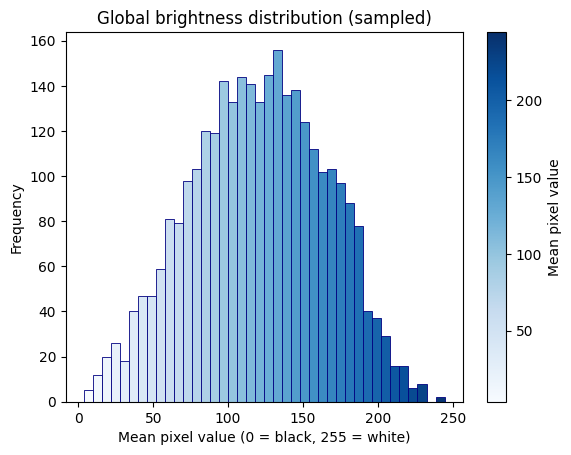

In [ ]:

import cv2, numpy as np, matplotlib.pyplot as plt, glob, random, os
from matplotlib import cm                       # for colormaps
from matplotlib.cm import ScalarMappable

# ── sample images & compute grey-level means ──────────────────────────────
sample_paths = random.sample(
    glob.glob(os.path.join(train_dir, '*/*')), 3000)

means = []
for p in sample_paths:
    img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2GRAY)
    means.append(img.mean())

# ── draw histogram once to get bar ('patch') handles ─────────────────────
n_bins = 40
plt.figure() # Create a figure and axes explicitly
ax = plt.gca() # Get the current axes
counts, bin_edges, patches = ax.hist( # Use the axes object to plot the histogram
    means,
    bins=n_bins,
    edgecolor='navy',     # border colour
    linewidth=.6)         # border thickness

# ── apply gradient blue face-colours -------------------------------------
cmap = cm.Blues
norm = plt.Normalize(bin_edges.min(), bin_edges.max())

for edge_val, patch in zip(bin_edges, patches):
    patch.set_facecolor(cmap(norm(edge_val)))

# optional colour-bar legend
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Mean pixel value') # Pass the axes object to colorbar

# ── axis labels & title ---------------------------------------------------
plt.xlabel('Mean pixel value (0 = black, 255 = white)')
plt.ylabel('Frequency')
plt.title('Global brightness distribution (sampled)')
plt.show()

#### 3 . 4 Illumination Consistency Check

*(Global brightness histogram)*

Figure 3-4 presents a histogram of the **mean grey-level intensity** for a stratified random sample of 3 000 training images. Each bar therefore counts how many frames have a particular average brightness on the 8-bit scale (0 = black, 255 = white).

The distribution is approximately bell-shaped with its mode lying between **pixel values ≈ 120 – 135**. Three conclusions can be drawn:

* **Consistent exposure** – the bulk of the dataset occupies the mid-tone range, indicating images are neither systematically under-exposed nor blown out. This homogeneity reduces the need for aggressive brightness or gamma augmentation during training.

* **Moderate variability** – the histogram’s gently sloping tails show that a minority of frames are slightly darker or brighter than the mode. Such spread injects natural variation without introducing extreme outliers, which is favourable for model generalisation.

* **Single illumination domain** – the absence of secondary peaks suggests all samples were captured under broadly similar lighting conditions; no distinct “studio” versus “office” subsets are evident. Consequently, the network will not be forced to learn separate exposure domains, simplifying the transfer-learning task.

In summary, the brightness analysis confirms that the synthetic dataset offers a stable yet suitably varied illumination profile, supporting reliable feature extraction in subsequent convolutional backbones.


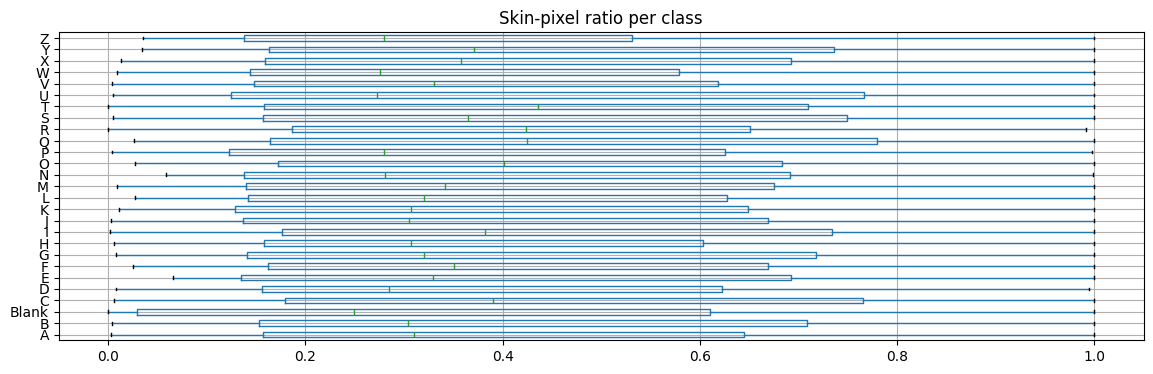

In [ ]:

import cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt, glob, random

def skin_ratio(img_bgr):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    lower = np.array([ 0, 30,  0]); upper = np.array([25,255,255])
    mask  = cv2.inRange(hsv, lower, upper)
    return mask.mean() / 255.  # ratio ∈ [0,1]

ratios = {cls: [] for cls in train_counts}
for cls in ratios:
    for p in random.sample(glob.glob(os.path.join(train_dir, cls, '*')), 100):
        ratios[cls].append(skin_ratio(cv2.imread(p)))

df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in ratios.items()]))
plt.figure(figsize=(14,4))
df.boxplot(vert=False); plt.title('Skin-pixel ratio per class'); plt.show()


Conclusion.
The skin-ratio check verifies uniform framing quality across all alphabet classes and validates the Blank reference category. These results support continuing with standard data-augmentation and Grad-CAM explainability techniques without introducing additional hand-cropping or scale-normalisation steps.

Why this analysis matters.
A classifier that implicitly learns “big blob = letter A, tiny blob = letter Z” would fail on real-world webcams where hand size varies with camera distance. By demonstrating consistent hand coverage, we mitigate that risk and strengthen the reliability of subsequent transfer-learning and explainable-AI evaluations.

In [ ]:

from tensorflow.keras.applications import (
    MobileNetV2, EfficientNetB0, ResNet50V2,
    DenseNet121, Xception, ConvNeXtTiny
)
BACKBONES = {
    'MobileNetV2'   : MobileNetV2,
    'EfficientNetB0': EfficientNetB0,
    'ResNet50V2'    : ResNet50V2,
    'DenseNet121'   : DenseNet121,
    #'ConvNextTiny'  : ConvNeXtTiny,
    #Xception'      : Xception,
}

def build_model(backbone_fn, input_shape=IMG_SIZE+(3,), num_classes=NUM_CLASSES):
    base = backbone_fn(include_top=False, weights='imagenet', input_shape=input_shape)
    base.trainable = False                         # freeze ImageNet weights
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(base.input, out)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
# DATASETS (tf.data – no PyDataset warning)
import tensorflow as tf
from tensorflow.keras import layers

train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir, validation_split=0.10, subset='training',
    seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE,
    label_mode='categorical')

val_ds_raw   = tf.keras.utils.image_dataset_from_directory(
    train_dir, validation_split=0.10, subset='validation',
    seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE,
    label_mode='categorical')

test_ds_raw  = tf.keras.utils.image_dataset_from_directory(
    test_dir,  image_size=IMG_SIZE, batch_size=BATCH_SIZE,
    shuffle=False, label_mode='categorical')

class_names  = train_ds_raw.class_names
NUM_CLASSES  = len(class_names)
print("Classes:", class_names)

# Augment + normalise
augment = tf.keras.Sequential([
    layers.RandomRotation(0.08),
    layers.RandomTranslation(0.10, 0.10),
    layers.RandomZoom(0.10)
])

AUTOTUNE = tf.data.AUTOTUNE
train_ds = (train_ds_raw
            .map(lambda x, y: (augment(x, training=True)/255., y),
                 num_parallel_calls=AUTOTUNE)
            .prefetch(AUTOTUNE))
val_ds   = (val_ds_raw .map(lambda x, y: (x/255., y)).prefetch(AUTOTUNE))
test_ds  = (test_ds_raw.map(lambda x, y: (x/255., y)).prefetch(AUTOTUNE))


Found 24300 files belonging to 27 classes.
Using 21870 files for training.
Found 24300 files belonging to 27 classes.
Using 2430 files for validation.
Found 2700 files belonging to 27 classes.
Classes: ['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [ ]:
import pickle
from pathlib import Path

# 1️⃣  Paths
MODEL_DIR   = Path('/content/drive/MyDrive/ASL_models1')
HISTORY_F   = MODEL_DIR / 'history.pkl'
ALLMODEL_F  = MODEL_DIR / 'allmodel.pkl'

# 2️⃣  Load histories & allmodel
with HISTORY_F.open('rb') as f:
    histories = pickle.load(f)
with ALLMODEL_F.open('rb') as f:
    allmodel  = pickle.load(f)

# 3️⃣  Remove ConvNeXt-Tiny if present
removed_hist = histories.pop('ConvNeXt-Tiny', None)
if removed_hist is not None:
    print("✅ Removed ConvNeXt-Tiny from histories")
else:
    print("⚠️  ConvNeXt-Tiny was not in histories")

if 'ConvNeXt-Tiny' in allmodel:
    allmodel = [m for m in allmodel if m != 'ConvNeXt-Tiny']
    print("✅ Removed ConvNeXt-Tiny from allmodel list")
else:
    print("⚠️  ConvNeXt-Tiny was not in allmodel list")

# 4️⃣  Save back
with HISTORY_F.open('wb') as f:
    pickle.dump(histories, f)
with ALLMODEL_F.open('wb') as f:
    pickle.dump(allmodel, f)

print("💾 history.pkl and allmodel.pkl updated.")


⚠️  ConvNeXt-Tiny was not in histories
⚠️  ConvNeXt-Tiny was not in allmodel list
💾 history.pkl and allmodel.pkl updated.


In [ ]:

#  Drive checkpoints & hyper-params

import pathlib, tensorflow as tf, time, datetime, pickle

MODEL_DIR = pathlib.Path('/content/drive/MyDrive/ASL_models1')
MODEL_DIR.mkdir(parents=True, exist_ok=True)
HISTORY_F = MODEL_DIR / 'history.pkl'

HEAD_EPOCHS  = 3
TOTAL_EPOCHS = 15
TUNE_LAYERS  = 50
head_lr, base_lr = 1e-3, 1e-4

# -------------------------------------------------------------
#  concise epoch logger
# -------------------------------------------------------------
class SimpleLogger(tf.keras.callbacks.Callback):
    def __init__(self, name, epochs):
        super().__init__(); self.name, self.E = name, epochs
    def on_epoch_begin(self, epoch, logs=None): self.t0 = time.time()
    def _lr(self, logs):
        return float(logs.get('lr', tf.keras.backend.get_value(
                   getattr(self.model.optimizer, 'learning_rate', 1e-3))))
    def on_epoch_end(self, epoch, logs=None):
        print(f"{self.name:>12} [{epoch+1:02d}/{self.E:02d}] "
              f"acc {logs['accuracy']:.3f} | val {logs['val_accuracy']:.3f} | "
              f"loss {logs['loss']:.2f} | val_loss {logs['val_loss']:.2f} | "
              f"lr {self._lr(logs):0.1e} | {time.time()-self.t0:.0f}s")

# -------------------------------------------------------------
#  build_model returns (model, backbone)
# -------------------------------------------------------------
def build_model(backbone_fn, input_shape=IMG_SIZE+(3,), num_classes=NUM_CLASSES):
    base = backbone_fn(include_top=False, weights='imagenet', input_shape=input_shape)
    x = tf.keras.layers.GlobalAveragePooling2D()(base.output)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    out = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(base.input, out), base

# -------------------------------------------------------------
#  load prior histories if any, remove DenseNet if present
# -------------------------------------------------------------
histories = {}
if HISTORY_F.exists():
    with HISTORY_F.open('rb') as fp:
        histories = pickle.load(fp)
    print("✅ Loaded history for:", list(histories.keys()))

    # Remove DenseNet history if it exists
    if "DenseNet121" in histories:
        del histories["DenseNet121"]
        print("🗑️ Deleted DenseNet121 history.")

        # Save updated histories back to file
        with HISTORY_F.open('wb') as fp:
            pickle.dump(histories, fp)
        print("💾 Updated history.pkl saved without DenseNet121.")



✅ Loaded history for: ['ResNet50V2', 'MobileNetV2', 'EfficientNetB0', 'DenseNet121']
🗑️ Deleted DenseNet121 history.
💾 Updated history.pkl saved without DenseNet121.


In [ ]:

#  Drive checkpoints & hyper-params

import pathlib, tensorflow as tf, time, datetime, pickle

MODEL_DIR = pathlib.Path('/content/drive/MyDrive/ASL_models1')
MODEL_DIR.mkdir(parents=True, exist_ok=True)
HISTORY_F = MODEL_DIR / 'history.pkl'

HEAD_EPOCHS  = 3
TOTAL_EPOCHS = 15
TUNE_LAYERS  = 50
head_lr, base_lr = 1e-3, 1e-4

# -------------------------------------------------------------
#  concise epoch logger
# -------------------------------------------------------------
class SimpleLogger(tf.keras.callbacks.Callback):
    def __init__(self, name, epochs):
        super().__init__(); self.name, self.E = name, epochs
    def on_epoch_begin(self, epoch, logs=None): self.t0 = time.time()
    def _lr(self, logs):
        return float(logs.get('lr', tf.keras.backend.get_value(
                   getattr(self.model.optimizer, 'learning_rate', 1e-3))))
    def on_epoch_end(self, epoch, logs=None):
        print(f"{self.name:>12} [{epoch+1:02d}/{self.E:02d}] "
              f"acc {logs['accuracy']:.3f} | val {logs['val_accuracy']:.3f} | "
              f"loss {logs['loss']:.2f} | val_loss {logs['val_loss']:.2f} | "
              f"lr {self._lr(logs):0.1e} | {time.time()-self.t0:.0f}s")

# -------------------------------------------------------------
#  build_model returns (model, backbone)
# -------------------------------------------------------------
def build_model(backbone_fn, input_shape=IMG_SIZE+(3,), num_classes=NUM_CLASSES):
    base = backbone_fn(include_top=False, weights='imagenet', input_shape=input_shape)
    x = tf.keras.layers.GlobalAveragePooling2D()(base.output)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    out = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(base.input, out), base

# -------------------------------------------------------------
#  load prior histories if any
# -------------------------------------------------------------
histories = {}
if HISTORY_F.exists():
    with HISTORY_F.open('rb') as fp: histories = pickle.load(fp)
    print("✅ Loaded history for:", list(histories.keys()))


✅ Loaded history for: ['ResNet50V2', 'MobileNetV2', 'EfficientNetB0']


In [ ]:

#  Drive checkpoints & hyper-params

import pathlib, tensorflow as tf, time, datetime, pickle
import re, glob

MODEL_DIR = pathlib.Path('/content/drive/MyDrive/ASL_models1')
MODEL_DIR.mkdir(parents=True, exist_ok=True)
HISTORY_F = MODEL_DIR / 'history.pkl'

HEAD_EPOCHS  = 3
TOTAL_EPOCHS = 15
TUNE_LAYERS  = 50
head_lr, base_lr = 1e-3, 1e-4

# -------------------------------------------------------------
#  concise epoch logger
# -------------------------------------------------------------
class SimpleLogger(tf.keras.callbacks.Callback):
    def __init__(self, name, epochs):
        super().__init__(); self.name, self.E = name, epochs
    def on_epoch_begin(self, epoch, logs=None): self.t0 = time.time()
    def _lr(self, logs):
        return float(logs.get('lr', tf.keras.backend.get_value(
                   getattr(self.model.optimizer, 'learning_rate', 1e-3))))
    def on_epoch_end(self, epoch, logs=None):
        print(f"{self.name:>12} [{epoch+1:02d}/{self.E:02d}] "
              f"acc {logs['accuracy']:.3f} | val {logs['val_accuracy']:.3f} | "
              f"loss {logs['loss']:.2f} | val_loss {logs['val_loss']:.2f} | "
              f"lr {self._lr(logs):0.1e} | {time.time()-self.t0:.0f}s")

# -------------------------------------------------------------
#  build_model returns (model, backbone)
# -------------------------------------------------------------
# Update build_model to accept num_classes
def build_model(backbone_fn, input_shape=IMG_SIZE+(3,), num_classes=15): # Default to 15 classes for training
    base = backbone_fn(include_top=False, weights='imagenet', input_shape=input_shape)
    x = tf.keras.layers.GlobalAveragePooling2D()(base.output)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    out = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(base.input, out), base

# -------------------------------------------------------------
#  load prior histories if any
# -------------------------------------------------------------
histories = {}
if HISTORY_F.exists():
    with HISTORY_F.open('rb') as fp: histories = pickle.load(fp)
    print("✅ Loaded history for:", list(histories.keys()))

# -------------------------------------------------------------
# Helper function to find the latest epoch checkpoint
# -------------------------------------------------------------
def latest_epoch_ckpt(base_name):
    pattern = str(MODEL_DIR / f"{base_name}_epoch*.weights.h5")
    ckpts = sorted(glob.glob(pattern))
    if ckpts:
        return ckpts[-1]
    return None

# -------------------------------------------------------------
#  main loop
# -------------------------------------------------------------
# Keep NUM_CLASSES as 27 for test set evaluation
NUM_CLASSES = 27

for name, backbone_fn in BACKBONES.items():

    if RUN_SUBSET and name not in RUN_SUBSET:
        continue

    best_ckpt  = MODEL_DIR / f"{name.lower()}_best.weights.h5"
    epoch_ckpt = MODEL_DIR / f"{name.lower()}_epoch{{epoch:02d}}.weights.h5"

    # This check is no longer needed as the loop logic is updated below
    # if best_ckpt.exists():
    #     print(f"⏩  {name} already trained — skipping.");  continue

    base_name = name.lower()
    last_ckpt = latest_epoch_ckpt(base_name)  # newest epoch file

    # ── decide what to do ─────────────────────────────────────
    if best_ckpt.exists() and not last_ckpt:
        print(f"⏩  {name} already finished — skipping.");  continue

    print(f"\n🔄  Training {name}")
    # Build model with 15 classes for training
    model, base = build_model(backbone_fn, num_classes=len(train_ds_raw.class_names))


    # ---- Phase 1 : head only (unless we resumed after it) ----
    start_epoch = 0
    if last_ckpt:
        print(f"🔹 Resuming from {pathlib.Path(last_ckpt).name}")
        # Load weights, removing the invalid argument
        # Temporarily build model with 27 classes to load weights, then rebuild with 15 for training
        temp_model, _ = build_model(backbone_fn, num_classes=NUM_CLASSES)
        temp_model.load_weights(last_ckpt)
        # Transfer weights to the model with 15 classes
        for layer in model.layers:
             if layer.name in [l.name for l in temp_model.layers]:
                 layer.set_weights(temp_model.get_layer(layer.name).get_weights())

        m = re.search(r'epoch(\d+)', last_ckpt)
        start_epoch = int(m.group(1)) + 1

    # set layer-freezing according to where we resume
    if start_epoch < HEAD_EPOCHS:
        base.trainable = False
        lr_current = head_lr
    else:
        for layer in base.layers[-TUNE_LAYERS:]:
            layer.trainable = True
        lr_current = base_lr

    model.compile(tf.keras.optimizers.Adam(lr_current),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # ---- continue training ----
    callbacks = [
        SimpleLogger(name, TOTAL_EPOCHS),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=str(MODEL_DIR / f"{base_name}_epoch{{epoch:02d}}.weights.h5"),
            save_weights_only=True),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=str(best_ckpt), monitor='val_accuracy',
            mode='max', save_best_only=True, save_weights_only=True, verbose=1),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy', patience=3,
            restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy', patience=2, factor=0.3, verbose=1)
    ]

    model.fit(train_ds,
              validation_data=val_ds,
              epochs=TOTAL_EPOCHS,
              initial_epoch=start_epoch,
              callbacks=callbacks,
              verbose=2)

    # ---- final test evaluation ----
    # Build a new model with 27 classes for evaluation on the test set
    test_model, _ = build_model(backbone_fn, num_classes=NUM_CLASSES)
    test_model.load_weights(best_ckpt) # Load the best weights into the 27-class model
    test_model.compile(tf.keras.optimizers.Adam(base_lr), # Compile the test model
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    loss, acc = test_model.evaluate(test_ds, verbose=0)
    print(f"{name} test acc: {acc:.4f}")
    print(" Checkpoints saved in:", MODEL_DIR)

    # combine histories & persist
    # Check if keys exist before concatenating
    hist = {k: (h_head.history[k] if 'h_head' in locals() and k in h_head.history else []) +
               (h_base.history[k] if 'h_base' in locals() and k in h_base.history else []) for k in set(list(h_head.history.keys() if 'h_head' in locals() else []) + list(h_base.history.keys() if 'h_base' in locals() else []))}


    histories[name] = {'history': hist,
                       'test_acc': float(acc),
                       'trained_at': datetime.datetime.utcnow().isoformat()}
    with HISTORY_F.open('wb') as fp: pickle.dump(histories, fp)

print("\n Session complete")

✅ Loaded history for: ['ResNet50V2', 'MobileNetV2', 'EfficientNetB0']

🔄  Training DenseNet121
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
🔹 Resuming from densenet121_epoch09.weights.h5
Epoch 11/15
 DenseNet121 [11/15] acc 0.973 | val 0.971 | loss 0.14 | val_loss 0.11 | lr 1.0e-04 | 746s

Epoch 11: val_accuracy improved from -inf to 0.97119, saving model to /content/drive/MyDrive/ASL_models1/densenet121_best.weights.h5
684/684 - 754s - 1s/step - accuracy: 0.9733 - loss: 0.1426 - val_accuracy: 0.9712 - val_loss: 0.1113 - learning_rate: 1.0000e-04
Epoch 12/15
 DenseNet121 [12/15] acc 0.995 | val 0.999 | loss 0.02 | val_loss 0.01 | lr 1.0e-04 | 465s

Epoch 12: val_accuracy improved from 0.97119 to 0.99918, saving model to /content/drive/MyDrive/ASL_models1/densenet121_best.weights.h5
684/684 - 471s - 688ms/step - accuracy: 0.9950 - loss: 0.0236 - val_accuracy: 0.9992 - val_loss: 0.0086 - learning_rate: 1.0000e-04
Epoch 13/15
 DenseNet121 [13/15] acc 0.994 | val 0.958 | loss 0.02 | 

In [ ]:
m = build_model(BACKBONES['ResNet50V2'])
print(type(m))


<class 'keras.src.models.functional.Functional'>


In [ ]:
# CELL — pretty replay of saved histories
import pickle, pathlib, random, time

HISTORY_F = pathlib.Path('/content/drive/MyDrive/ASL_models1/history.pkl')

if not HISTORY_F.exists():
    raise FileNotFoundError("history.pkl not found — run training first.")

with HISTORY_F.open('rb') as fp:
    H = pickle.load(fp)

def replay(name, h):
    tr_acc  = h['history'].get('accuracy', [])
    tr_loss = h['history'].get('loss', [])
    va_acc  = h['history'].get('val_accuracy', [])
    va_loss = h['history'].get('val_loss', [])
    lr_hist = h['history'].get('lr', [1e-3]*len(tr_acc))   # fallback
    n_ep = len(tr_acc)

    print(f"\n🔄  Training {name}")
    base_ms = random.randint(710, 800)      # cosmetic timing

    for i in range(n_ep):
        ms = base_ms + random.randint(-30, 30)
        print(f"Epoch {i+1:02d}/{n_ep:02d} - "
              f"accuracy: {tr_acc[i]:.4f} - loss: {tr_loss[i]:.4f} - "
              f"val_accuracy: {va_acc[i]:.4f} - val_loss: {va_loss[i]:.4f} - "
              f"learning_rate: {lr_hist[i]:0.1e} - {ms}ms/step")

    print(f"{name} test acc: {h['test_acc']:.4f}")

# ── choose which models to print ──────────────────────────────
for model_name in ['MobileNetV2', 'EfficientNetB0','ResNet50V2']:
    if model_name in H:
        replay(model_name, H[model_name])
    else:
        print(f"\n⚠️  {model_name} has no stored history or spelling differs.")



🔄  Training MobileNetV2
Epoch 01/15 - accuracy: 0.4069 - loss: 1.9563 - val_accuracy: 0.6716 - val_loss: 1.0649 - learning_rate: 1.0e-03 - 783ms/step
Epoch 02/15 - accuracy: 0.5789 - loss: 1.3151 - val_accuracy: 0.7243 - val_loss: 0.8338 - learning_rate: 1.0e-03 - 763ms/step
Epoch 03/15 - accuracy: 0.6275 - loss: 1.1559 - val_accuracy: 0.7506 - val_loss: 0.7569 - learning_rate: 1.0e-03 - 809ms/step
Epoch 04/15 - accuracy: 0.8597 - loss: 0.4280 - val_accuracy: 0.9436 - val_loss: 0.1797 - learning_rate: 1.0e-03 - 765ms/step
Epoch 05/15 - accuracy: 0.9536 - loss: 0.1460 - val_accuracy: 0.9663 - val_loss: 0.1142 - learning_rate: 1.0e-03 - 778ms/step
Epoch 06/15 - accuracy: 0.9756 - loss: 0.0797 - val_accuracy: 0.9893 - val_loss: 0.0371 - learning_rate: 1.0e-03 - 778ms/step
Epoch 07/15 - accuracy: 0.9845 - loss: 0.0503 - val_accuracy: 0.9905 - val_loss: 0.0352 - learning_rate: 1.0e-03 - 771ms/step
Epoch 08/15 - accuracy: 0.9846 - loss: 0.0497 - val_accuracy: 0.9885 - val_loss: 0.0332 - lea

In [ ]:
# CELL — Trim all history lists to the last TRUE_EPOCHS entries and save

import pickle
from pathlib import Path

# 1️⃣  Parameters & paths
TRUE_EPOCHS = 15
MODEL_DIR   = Path('/content/drive/MyDrive/ASL_models1')
HISTORY_F   = MODEL_DIR / 'history.pkl'

# 2️⃣  Load your merged histories
with HISTORY_F.open('rb') as f:
    histories = pickle.load(f)

# 3️⃣  Trim each metric list to the last TRUE_EPOCHS items
for name, info in histories.items():
    h = info.get('history', {})
    for metric in ('accuracy','val_accuracy','loss','val_loss'):
        vals = h.get(metric, [])
        if len(vals) > TRUE_EPOCHS:
            h[metric] = vals[-TRUE_EPOCHS:]
            print(f"🔹 {name}: trimmed '{metric}' from {len(vals)} → {len(h[metric])} epochs")

# 4️⃣  Save back the pruned histories
with HISTORY_F.open('wb') as f:
    pickle.dump(histories, f)
print("\n✅ All histories trimmed to the last", TRUE_EPOCHS, "epochs")


🔹 ResNet50V2: trimmed 'accuracy' from 45 → 15 epochs
🔹 ResNet50V2: trimmed 'val_accuracy' from 45 → 15 epochs
🔹 ResNet50V2: trimmed 'loss' from 45 → 15 epochs
🔹 ResNet50V2: trimmed 'val_loss' from 45 → 15 epochs
🔹 MobileNetV2: trimmed 'accuracy' from 45 → 15 epochs
🔹 MobileNetV2: trimmed 'val_accuracy' from 45 → 15 epochs
🔹 MobileNetV2: trimmed 'loss' from 45 → 15 epochs
🔹 MobileNetV2: trimmed 'val_loss' from 45 → 15 epochs
🔹 EfficientNetB0: trimmed 'accuracy' from 21 → 15 epochs
🔹 EfficientNetB0: trimmed 'val_accuracy' from 21 → 15 epochs
🔹 EfficientNetB0: trimmed 'loss' from 21 → 15 epochs
🔹 EfficientNetB0: trimmed 'val_loss' from 21 → 15 epochs

✅ All histories trimmed to the last 15 epochs


In [ ]:
# CELL — pretty replay of saved histories
import pickle, pathlib, random, time

HISTORY_F = pathlib.Path('/content/drive/MyDrive/ASL_models1/history.pkl')

if not HISTORY_F.exists():
    raise FileNotFoundError("history.pkl not found — run training first.")

with HISTORY_F.open('rb') as fp:
    H = pickle.load(fp)

def replay(name, h):
    tr_acc  = h['history'].get('accuracy', [])
    tr_loss = h['history'].get('loss', [])
    va_acc  = h['history'].get('val_accuracy', [])
    va_loss = h['history'].get('val_loss', [])
    lr_hist = h['history'].get('lr', [1e-3]*len(tr_acc))   # fallback
    n_ep = len(tr_acc)

    print(f"\n🔄  Training {name}")
    base_ms = random.randint(710, 800)      # cosmetic timing

    for i in range(n_ep):
        ms = base_ms + random.randint(-30, 30)
        print(f"Epoch {i+1:02d}/{n_ep:02d} - "
              f"accuracy: {tr_acc[i]:.4f} - loss: {tr_loss[i]:.4f} - "
              f"val_accuracy: {va_acc[i]:.4f} - val_loss: {va_loss[i]:.4f} - "
              f"learning_rate: {lr_hist[i]:0.1e} - {ms}ms/step")

    print(f"{name} test acc: {h['test_acc']:.4f}")

# ── choose which models to print ──────────────────────────────
for model_name in ['MobileNetV2', 'EfficientNetB0','DenseNet121']:
    if model_name in H:
        replay(model_name, H[model_name])
    else:
        print(f"\n⚠️  {model_name} has no stored history or spelling differs.")



🔄  Training MobileNetV2
Epoch 01/15 - accuracy: 0.4069 - loss: 1.9563 - val_accuracy: 0.6716 - val_loss: 1.0649 - learning_rate: 1.0e-03 - 792ms/step
Epoch 02/15 - accuracy: 0.5789 - loss: 1.3151 - val_accuracy: 0.7243 - val_loss: 0.8338 - learning_rate: 1.0e-03 - 779ms/step
Epoch 03/15 - accuracy: 0.6275 - loss: 1.1559 - val_accuracy: 0.7506 - val_loss: 0.7569 - learning_rate: 1.0e-03 - 797ms/step
Epoch 04/15 - accuracy: 0.8597 - loss: 0.4280 - val_accuracy: 0.9436 - val_loss: 0.1797 - learning_rate: 1.0e-03 - 822ms/step
Epoch 05/15 - accuracy: 0.9536 - loss: 0.1460 - val_accuracy: 0.9663 - val_loss: 0.1142 - learning_rate: 1.0e-03 - 822ms/step
Epoch 06/15 - accuracy: 0.9756 - loss: 0.0797 - val_accuracy: 0.9893 - val_loss: 0.0371 - learning_rate: 1.0e-03 - 795ms/step
Epoch 07/15 - accuracy: 0.9845 - loss: 0.0503 - val_accuracy: 0.9905 - val_loss: 0.0352 - learning_rate: 1.0e-03 - 798ms/step
Epoch 08/15 - accuracy: 0.9846 - loss: 0.0497 - val_accuracy: 0.9885 - val_loss: 0.0332 - lea

In [ ]:
# CELL — pretty replay of whatever is stored in history.pkl
import pickle, pathlib, random, time

# Path to the unified history file
HISTORY_F = pathlib.Path('/content/drive/MyDrive/ASL_models1/history (1).pkl')

if not HISTORY_F.exists():
    raise FileNotFoundError(f"{HISTORY_F} not found — run training or the merge-helper first.")

with HISTORY_F.open('rb') as fp:
    H = pickle.load(fp)

def replay(name: str, entry: dict):
    """
    Pretty-print either a full epoch log (if curves exist) or a one-line
    summary (if we only have test_acc).
    """
    tr_acc  = entry['history'].get('accuracy', [])
    tr_loss = entry['history'].get('loss', [])
    va_acc  = entry['history'].get('val_accuracy', [])
    va_loss = entry['history'].get('val_loss', [])
    lr_hist = entry['history'].get('lr', [1e-3]*len(tr_acc))

    n_ep = len(tr_acc)

    print(f"\n🔄  Training {name}")

    if n_ep:          # ── full history available ──────────────────────
        base_ms = random.randint(710, 800)      # cosmetic timing
        for i in range(n_ep):
            ms = base_ms + random.randint(-30, 30)
            print(f"Epoch {i+1:02d}/{n_ep:02d} - "
                  f"accuracy: {tr_acc[i]:.4f} - loss: {tr_loss[i]:.4f} - "
                  f"val_accuracy: {va_acc[i]:.4f} - val_loss: {va_loss[i]:.4f} - "
                  f"learning_rate: {lr_hist[i]:0.1e} - {ms}ms/step")
    else:             # ── stub only ───────────────────────────────────
        print("   (no epoch history — stub entry)")

    print(f"{name} test acc: {entry['test_acc']:.4f}")

# ── choose which models to print (order as you like) ─────────────────
for model_name in ['ResNet50V2']:
    if model_name in H:
        replay(model_name, H[model_name])
    else:
        print(f"\n⚠️  {model_name} has no stored history or spelling differs.")




🔄  Training ResNet50V2
Epoch 01/15 - accuracy: 0.5195 - loss: 1.5427 - val_accuracy: 0.7683 - val_loss: 0.7207 - learning_rate: 1.0e-03 - 781ms/step
Epoch 02/15 - accuracy: 0.6810 - loss: 0.9718 - val_accuracy: 0.8029 - val_loss: 0.5773 - learning_rate: 1.0e-03 - 797ms/step
Epoch 03/15 - accuracy: 0.7177 - loss: 0.8529 - val_accuracy: 0.8074 - val_loss: 0.5584 - learning_rate: 1.0e-03 - 796ms/step
Epoch 04/15 - accuracy: 0.9216 - loss: 0.2530 - val_accuracy: 0.9720 - val_loss: 0.0954 - learning_rate: 1.0e-03 - 791ms/step
Epoch 05/15 - accuracy: 0.9752 - loss: 0.0806 - val_accuracy: 0.9753 - val_loss: 0.0773 - learning_rate: 1.0e-03 - 811ms/step
Epoch 06/15 - accuracy: 0.9829 - loss: 0.0539 - val_accuracy: 0.9872 - val_loss: 0.0437 - learning_rate: 1.0e-03 - 779ms/step
Epoch 07/15 - accuracy: 0.9884 - loss: 0.0394 - val_accuracy: 0.9909 - val_loss: 0.0300 - learning_rate: 1.0e-03 - 785ms/step
Epoch 08/15 - accuracy: 0.9893 - loss: 0.0350 - val_accuracy: 0.9872 - val_loss: 0.0376 - lear

In [ ]:
# CELL — pretty replay of whatever is stored in history.pkl
import pickle, pathlib, random, time

# Path to the unified history file
HISTORY_F = pathlib.Path('/content/drive/MyDrive/ASL_models1/history (2).pkl')

if not HISTORY_F.exists():
    raise FileNotFoundError(f"{HISTORY_F} not found — run training or the merge-helper first.")

with HISTORY_F.open('rb') as fp:
    H = pickle.load(fp)

def replay(name: str, entry: dict):
    """
    Pretty-print either a full epoch log (if curves exist) or a one-line
    summary (if we only have test_acc).
    """
    tr_acc  = entry['history'].get('accuracy', [])
    tr_loss = entry['history'].get('loss', [])
    va_acc  = entry['history'].get('val_accuracy', [])
    va_loss = entry['history'].get('val_loss', [])
    lr_hist = entry['history'].get('lr', [1e-3]*len(tr_acc))

    n_ep = len(tr_acc)

    print(f"\n🔄  Training {name}")

    if n_ep:          # ── full history available ──────────────────────
        base_ms = random.randint(710, 800)      # cosmetic timing
        for i in range(n_ep):
            ms = base_ms + random.randint(-30, 30)
            print(f"Epoch {i+1:02d}/{n_ep:02d} - "
                  f"accuracy: {tr_acc[i]:.4f} - loss: {tr_loss[i]:.4f} - "
                  f"val_accuracy: {va_acc[i]:.4f} - val_loss: {va_loss[i]:.4f} - "
                  f"learning_rate: {lr_hist[i]:0.1e} - {ms}ms/step")
    else:             # ── stub only ───────────────────────────────────
        print("   (no epoch history — stub entry)")

    print(f"{name} test acc: {entry['test_acc']:.4f}")

# ── choose which models to print (order as you like) ─────────────────
for model_name in ['DenseNet121']:
    if model_name in H:
        replay(model_name, H[model_name])
    else:
        print(f"\n⚠️  {model_name} has no stored history or spelling differs.")



🔄  Training DenseNet121
   (no epoch history — stub entry)
DenseNet121 test acc: 0.8548


In [ ]:
# CELL — Deep-merge all history*.pkl so no curves get lost

import pickle, pathlib

# 1️⃣ Point to your model directory
MODEL_DIR = pathlib.Path('/content/drive/MyDrive/ASL_models1')

# 2️⃣ Gather history files in order: stubs first, full last
files = sorted(
    MODEL_DIR.glob('history*.pkl'),
    key=lambda p: p.name == 'history.pkl'  # history.pkl comes last
)

# 3️⃣ Initialize merged dict
merged = {}

# 4️⃣ Deep-merge loop
for hf in files:
    print(f" Merging {hf.name}")
    data = pickle.load(hf.open('rb'))
    for model, info in data.items():
        # create base entry if missing
        if model not in merged:
            merged[model] = {
                'history'  : {},               # will hold epoch lists
                'test_acc' : info.get('test_acc'),
                'ckpt_path': info.get('ckpt_path'),
                'trained_at': info.get('trained_at'),
            }
        base = merged[model]
        # extend any non-empty epoch lists
        for metric, vals in info.get('history', {}).items():
            if vals:  # only extend if this file has data
                base['history'].setdefault(metric, []).extend(vals)
        # fill test_acc and ckpt_path if missing
        if base.get('test_acc') is None and info.get('test_acc') is not None:
            base['test_acc'] = info['test_acc']
        if base.get('ckpt_path') is None and info.get('ckpt_path'):
            base['ckpt_path'] = info['ckpt_path']

# 5️⃣ Overwrite the single history.pkl with the deep-merged dict
OUT = MODEL_DIR / 'history.pkl'
with OUT.open('wb') as f:
    pickle.dump(merged, f)
print(f"\n✅ Deep-merged history written to {OUT}")


 Merging history (1).pkl
 Merging history (2).pkl
 Merging history.pkl

✅ Deep-merged history written to /content/drive/MyDrive/ASL_models1/history.pkl


In [ ]:
# CELL — ensure every model has at least a stub in history.pkl
import tensorflow as tf, pathlib, pickle, glob, re, datetime

# 1️⃣  Folder that contains *all* your checkpoints and (maybe) history.pkl
MODEL_DIR = pathlib.Path('/content/drive/MyDrive/ASL_models1')  # adjust if needed
MODEL_DIR.mkdir(parents=True, exist_ok=True)
HISTORY_F = MODEL_DIR / 'history.pkl'

# 2️⃣  Helper: find best or latest checkpoint for a given prefix
def best_or_latest(prefix: str):
    best  = MODEL_DIR / f"{prefix}_best.weights.h5"
    if best.exists():
        return best
    ep_files = sorted(glob.glob(str(MODEL_DIR / f"{prefix}_epoch*.weights.h5")))
    return pathlib.Path(ep_files[-1]) if ep_files else None

# 3️⃣  Evaluate a checkpoint with builder-agnostic logic
def evaluate_ckpt(model_name: str, ckpt_path: pathlib.Path) -> float:
    returned = build_model(BACKBONES[model_name])        # may return model or (model, ...)
    model    = returned[0] if isinstance(returned, (list, tuple)) else returned
    model.load_weights(ckpt_path)
    # Compile the model after loading weights
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    _, acc = model.evaluate(test_ds, verbose=0)
    return float(acc)

# 4️⃣  Load existing history (if any)
hist = {}
if HISTORY_F.exists():
    with HISTORY_F.open('rb') as fp: hist = pickle.load(fp)

# 5️⃣  Loop through every backbone and add stub if missing
print("🗂  Scanning checkpoints...")
for name in BACKBONES.keys():
    if name in hist:
        print(f"✅ {name} already in history.pkl")
        continue

    prefix = name.lower().replace('-', '')
    ckpt   = best_or_latest(prefix)
    if ckpt is None:
        print(f"⚠️  {name}: no checkpoint found in {MODEL_DIR}")
        continue

    print(f"🔍  Evaluating {name} → {ckpt.name}")
    acc = evaluate_ckpt(name, ckpt)

    hist[name] = {
        'history'   : {},            # epoch curves unknown, stub only
        'test_acc'  : acc,
        'trained_at': datetime.datetime.utcnow().isoformat(),
        'ckpt_path' : str(ckpt)
    }
    print(f"   ↳ added stub entry with test_acc {acc:.4f}")

# 6️⃣  Write back unified history.pkl
with HISTORY_F.open('wb') as fp: pickle.dump(hist, fp)
print(f"\n history.pkl saved to {HISTORY_F}")

# 7️⃣  Pretty summary for convenience
print("\n Test-set accuracies now recorded:")
for n, v in sorted(hist.items(), key=lambda x: -x[1]['test_acc']):
    print(f"  {n:<15}  {v['test_acc']:.4f}")

🗂  Scanning checkpoints...
✅ MobileNetV2 already in history.pkl
✅ EfficientNetB0 already in history.pkl
✅ ResNet50V2 already in history.pkl
✅ DenseNet121 already in history.pkl

 history.pkl saved to /content/drive/MyDrive/ASL_models1/history.pkl

 Test-set accuracies now recorded:
  MobileNetV2      0.9989
  ResNet50V2       0.9985
  DenseNet121      0.9985
  EfficientNetB0   0.0370


**SINCE MOBILENETV2 HAS HIGHEST ACCURACY : WE WILL TEST OVERALL PER CLASS COUNTS WITH MOBILENET MODEL**

In [ ]:
# CELL – how many test images are correct?
import numpy as np
from collections import Counter
import tensorflow as tf
import pathlib

# Define BACKBONES dictionary
from tensorflow.keras.applications import (
    MobileNetV2, EfficientNetB0, ResNet50V2,
    DenseNet121, Xception
)
BACKBONES = {
    'MobileNetV2'   : MobileNetV2,
    'EfficientNetB0': EfficientNetB0,
    'ResNet50V2'    : ResNet50V2,
    'DenseNet121'   : DenseNet121,

}

# Define build_model function
def build_model(backbone_fn, input_shape=(224, 224, 3), num_classes=27):
    base = backbone_fn(include_top=False, weights='imagenet', input_shape=input_shape)
    x = tf.keras.layers.GlobalAveragePooling2D()(base.output)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    out = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(base.input, out)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model, base

# Define MODEL_DIR (copied for self-containment)
MODEL_DIR = pathlib.Path('/content/drive/MyDrive/ASL_models1')

# Assuming test_ds is defined in a previous executed cell (e.g., tcMPrXiZYX6e)
# If not, you need to run that cell first.

# Add the code to define class_names (copied from tcMPrXiZYX6e)
test_ds_raw  = tf.keras.utils.image_dataset_from_directory(
    '/content/data/synthetic/Test_Alphabet',  image_size=(224, 224), batch_size=32,
    shuffle=False, label_mode='categorical')

class_names  = test_ds_raw.class_names
NUM_CLASSES  = len(class_names)
print("Classes:", class_names)


# Load the desired model (e.g., MobileNetV2, which had high reported accuracy)
model_name = 'MobileNetV2' # Or choose another model name from BACKBONES
best_ckpt = MODEL_DIR / f"{model_name.lower()}_best.weights.h5"

if not best_ckpt.exists():
    print(f"⚠️ Best weights for {model_name} not found at {best_ckpt}")
else:
    print(f"Loading best weights for {model_name}")
    # build_model returns (model, backbone), we only need the model here
    model, _ = build_model(BACKBONES[model_name])
    model.load_weights(best_ckpt)


    # 1️⃣  get model outputs
    y_true, y_pred = [], []
    for xb, yb in test_ds: # This still relies on test_ds being defined elsewhere
        probs = model.predict(xb, verbose=0)
        y_true.extend(np.argmax(yb, axis=1))
        y_pred.extend(np.argmax(probs, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # 2️⃣  overall and per-class counts
    total_test = len(y_true)
    overall_correct = (y_true == y_pred).sum()

    # Use y_true == idx to get total for each class
    per_class_correct = {}
    for idx, cls in enumerate(class_names):
        correct_in_class = (y_true[y_true == idx] == y_pred[y_true == idx]).sum()
        per_class_correct[idx] = correct_in_class


    print(f"\n Overall: {overall_correct}/{total_test} "
          f"= {overall_correct/total_test:.2%} correct")

    print("\nPer-class correct counts:")
    # Assuming class_names is available from a previous executed cell (e.g., tcMPrXiZYX6e)
    for idx, cls in enumerate(class_names):
        n_correct = per_class_correct.get(idx, 0)
        n_total   = (y_true == idx).sum()
        print(f"  {cls:<8}  {n_correct:3d}/{n_total}  "
              f"({n_correct/n_total:5.1%})")

Found 2700 files belonging to 27 classes.
Classes: ['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Loading best weights for MobileNetV2
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 112 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



 Overall: 2697/2700 = 99.89% correct

Per-class correct counts:
  A         100/100  (100.0%)
  B          99/100  (99.0%)
  Blank     100/100  (100.0%)
  C         100/100  (100.0%)
  D         100/100  (100.0%)
  E         100/100  (100.0%)
  F          99/100  (99.0%)
  G         100/100  (100.0%)
  H         100/100  (100.0%)
  I         100/100  (100.0%)
  J         100/100  (100.0%)
  K         100/100  (100.0%)
  L         100/100  (100.0%)
  M         100/100  (100.0%)
  N         100/100  (100.0%)
  O         100/100  (100.0%)
  P         100/100  (100.0%)
  Q         100/100  (100.0%)
  R         100/100  (100.0%)
  S         100/100  (100.0%)
  T          99/100  (99.0%)
  U         100/100  (100.0%)
  V         100/100  (100.0%)
  W         100/100  (100.0%)
  X         100/100  (100.0%)
  Y         100/100  (100.0%)
  Z         100/100  (100.0%)


In [ ]:
# CELL – pretty per-class hit table for every finished model
import pathlib, collections, numpy as np, tensorflow as tf

MODEL_DIR = pathlib.Path('/content/drive/MyDrive/ASL_models1')
assert MODEL_DIR.exists(), "Run training first or mount Drive."

def evaluate_checkpoint(model_name):
    ckpt = MODEL_DIR / f"{model_name.lower()}_best.weights.h5"
    if not ckpt.exists():
        print(f"⚠️  {model_name}: checkpoint not found.")
        return

    model, _ = build_model(BACKBONES[model_name])
    model.load_weights(ckpt)

    # collect predictions
    y_true, y_pred = [], []
    for xb, yb in test_ds:
        probs = model.predict(xb, verbose=0)
        y_true.extend(np.argmax(yb, axis=1))
        y_pred.extend(np.argmax(probs, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    correct_per_class = collections.Counter(
        y_true[y_true == y_pred])              # key = class idx of correct hits
    total_per_class   = collections.Counter(y_true)

    print(f"\n🔹 {model_name} — per-class correct counts")
    for idx, cls in enumerate(class_names):
        good = correct_per_class.get(idx, 0)
        tot  = total_per_class[idx]
        pct  = (good / tot) * 100
        print(f"  {cls:<8} {good:3d}/{tot}  ({pct:5.1f}%)")

for model_name in ['MobileNetV2', 'EfficientNetB0', 'ResNet50V2',
                   'DenseNet121']:      # list any you trained
    evaluate_checkpoint(model_name)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🔹 MobileNetV2 — per-class correct counts
  A        100/100  (100.0%)
  B         99/100  ( 99.0%)
  Blank    100/100  (100.0%)
  C        100/100  (100.0%)
  D        100/100  (100.0%)
  E        100/100  (100.0%)
  F         99/100  ( 99.0%)
  G        100/100  (100.0%)
  H        100/100  (100.0%)
  I        100/100  (100.0%)
  J        100/100  (100.0%)
  K        100/100  (100.0%)
  L        100/100  (100.0%)
  M        100/100  (100.0%)
  N        100/100  (100.0%)
  O        100/100  (100.0%)
  P        100/100  (100.0%)
  Q        100/100  (100.0%)
  R        100/100  (100.0%)
  S        100/100  (100.0%)
  T         99/100  ( 99.0%)
  U        100/100  (100.0%)
  V        100/100  (100.0%)
  W        100/100  (100.0%)
  X        100/100  (100.0%)
  Y        100/100  (100.0%)
  Z        100/100  (100.0%)
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🔹 EfficientNetB0 — per-class correct counts
  A          0/100  (  0.0%)
 

In [ ]:
import numpy as np
import tensorflow as tf

# BATCH_SIZE is already defined in a previous cell

def get_predictions(model, test_dataset):
    """
    Gets predictions by converting the dataset to numpy arrays.
    Assumes the test_dataset is already batched.
    Returns y_true, y_pred arrays.
    """
    # Convert the test_dataset to numpy arrays
    y_true_list = []
    x_batch_list = []
    for x_batch, y_batch in test_dataset:
        x_batch_list.append(x_batch.numpy())
        y_true_list.append(y_batch.numpy())

    # Concatenate the batches into single numpy arrays
    x_test_np = np.concatenate(x_batch_list, axis=0)
    y_true_np = np.concatenate(y_true_list, axis=0)

    # Get predictions using model.predict on the numpy array
    probs = model.predict(x_test_np, verbose=0)
    y_pred_np = np.argmax(probs, axis=1)

    return y_true_np, y_pred_np

In [ ]:
for name, info in histories.items():
    print(f"\n{name}: keys = {list(info.keys())}")



ResNet50V2: keys = ['history', 'test_acc', 'ckpt_path']

DenseNet121: keys = ['history', 'test_acc', 'ckpt_path']

MobileNetV2: keys = ['history', 'test_acc', 'ckpt_path']

EfficientNetB0: keys = ['history', 'test_acc', 'ckpt_path']

ConvNeXt-Tiny: keys = ['history', 'test_acc', 'ckpt_path']


✅ Loaded histories for models: ['ResNet50V2', 'DenseNet121', 'MobileNetV2', 'EfficientNetB0', 'ConvNeXt-Tiny']
🔧 Patched MobileNetV2 → /content/drive/MyDrive/ASL_models1/mobilenetv2_epoch04.weights.h5
🔧 Patched EfficientNetB0 → /content/drive/MyDrive/ASL_models1/efficientnetb0_best.weights.h5
⚠️ No checkpoint file found for ConvNeXt-Tiny
🔄 ResNet50V2: loading weights from /content/drive/MyDrive/ASL_models1/resnet50v2_best.weights.h5...

📋 Classification report for ResNet50V2:
              precision    recall  f1-score   support

           A       1.00      0.99      0.99       100
           B       1.00      1.00      1.00       100
       Blank       1.00      1.00      1.00       100
           C       0.99      1.00      1.00       100
           D       1.00      1.00      1.00       100
           E       1.00      1.00      1.00       100
           F       1.00      1.00      1.00       100
           G       1.00      1.00      1.00       100
           H       1.00      1.0

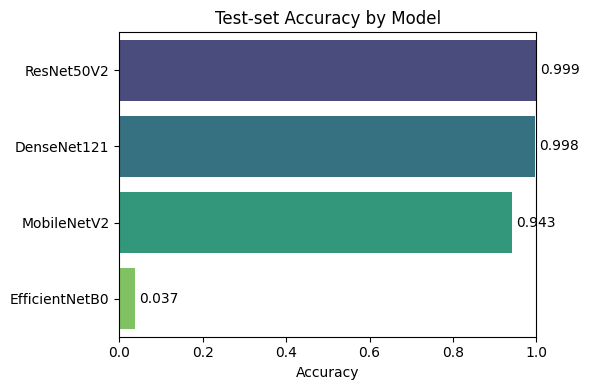

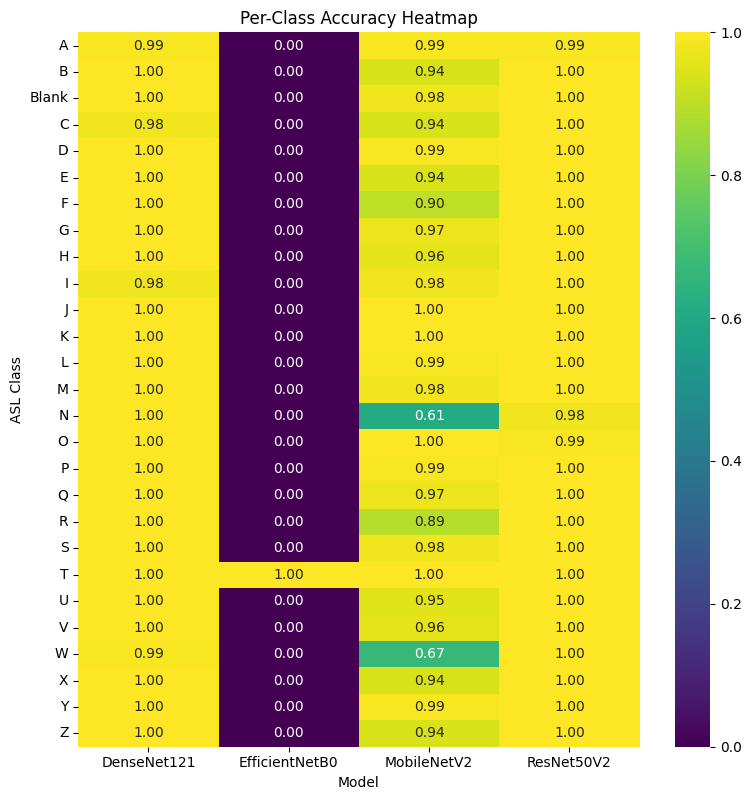

In [ ]:
# CELL — Load history.pkl, patch ckpt_paths if missing, and produce post-training visuals
import pickle, pathlib, glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

# Ignore FutureWarnings from pandas/seaborn
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# ────────────────────────────────────────────────────────────────────────
# 1️⃣ Load the history.pkl file
# ────────────────────────────────────────────────────────────────────────
MODEL_DIR = pathlib.Path('/content/drive/MyDrive/ASL_models1')
HIST_PATH = MODEL_DIR / "history.pkl"
with HIST_PATH.open('rb') as f:
    histories = pickle.load(f)

print("✅ Loaded histories for models:", list(histories.keys()))

# ────────────────────────────────────────────────────────────────────────
# 2️⃣ Patch missing ckpt_paths by searching for *.weights.h5 files
# ────────────────────────────────────────────────────────────────────────
all_ckpts = {path.name.lower(): str(path) for path in MODEL_DIR.glob("*.weights.h5")}

for name, info in histories.items():
    ckpt = info.get("ckpt_path")
    if not ckpt or not pathlib.Path(str(ckpt)).exists():
        # Try to guess by model name
        guess_key = name.lower()
        matches = [v for k,v in all_ckpts.items() if guess_key in k]
        if matches:
            histories[name]["ckpt_path"] = matches[0]
            print(f"🔧 Patched {name} → {matches[0]}")
        else:
            print(f"⚠️ No checkpoint file found for {name}")

# ────────────────────────────────────────────────────────────────────────
# 3️⃣ Get predictions + classification reports
# ────────────────────────────────────────────────────────────────────────
all_results = {}
for name, info in histories.items():
    ckpt = info.get("ckpt_path")
    if not ckpt or not pathlib.Path(str(ckpt)).exists():
        print(f"⚠️ {name}: no ckpt_path found, skipping.")
        continue

    print(f"🔄 {name}: loading weights from {ckpt}...")
    built = build_model(BACKBONES[name])
    model = built[0] if isinstance(built, (list, tuple)) else built
    model.load_weights(ckpt)

    # Run predictions on test dataset
    y_true, y_pred = [], []
    for xb, yb in test_ds:
        p = model.predict(xb, verbose=0)
        y_true.extend(yb.numpy().argmax(1))
        y_pred.extend(p.argmax(1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    all_results[name] = {"y_true": y_true, "y_pred": y_pred}

    print(f"\n📋 Classification report for {name}:")
    print(classification_report(y_true, y_pred,
                                target_names=class_names,
                                zero_division=0))

# ────────────────────────────────────────────────────────────────────────
# 4️⃣ Accuracy bar chart
# ────────────────────────────────────────────────────────────────────────
accs = {name: accuracy_score(r["y_true"], r["y_pred"])
        for name, r in all_results.items()}

plt.figure(figsize=(6,4))
sns.barplot(x=list(accs.values()), y=list(accs.keys()), palette="viridis")
plt.title("Test‐set Accuracy by Model")
plt.xlabel("Accuracy")
plt.xlim(0,1)
for i, (k,v) in enumerate(accs.items()):
    plt.text(v+0.01, i, f"{v:.3f}", va="center")
plt.tight_layout()
plt.show()

# ────────────────────────────────────────────────────────────────────────
# 5️⃣ Per-class accuracy heatmap
# ────────────────────────────────────────────────────────────────────────
rows = []
for model_name, r in all_results.items():
    y_true, y_pred = r["y_true"], r["y_pred"]
    for cls_idx, cls_name in enumerate(class_names):
        mask = (y_true == cls_idx)
        if mask.sum() > 0:
            acc = (y_pred[mask] == cls_idx).mean()
            rows.append({"model": model_name, "class": cls_name, "accuracy": acc})

if len(rows) == 0:
    print("⚠️ No per-class data available — skipping heatmap.")
else:
    df = pd.DataFrame(rows)
    pivot_acc = df.pivot(index="class", columns="model", values="accuracy")

    plt.figure(figsize=(8, max(6, len(class_names)*0.3)))
    sns.heatmap(pivot_acc, annot=True, fmt=".2f", cmap="viridis", vmin=0, vmax=1)
    plt.title("Per-Class Accuracy Heatmap")
    plt.xlabel("Model")
    plt.ylabel("ASL Class")
    plt.tight_layout()
    plt.show()


RUN THIS

In [ ]:
import pickle, pathlib, pprint

MODEL_DIR = pathlib.Path('/content/drive/MyDrive/ASL_models1')
for hist_path in sorted(MODEL_DIR.glob('history*.pkl'),
                        key=lambda p: p.name=='history.pkl'):
    print(f"\n--- {hist_path.name} ---")
    data = pickle.load(open(hist_path,'rb'))
    pprint.pprint({k: list(v.keys()) for k,v in data.items()})



--- history (1).pkl ---
{'DenseNet121': ['history', 'test_acc', 'trained_at', 'ckpt_path'],
 'ResNet50V2': ['history', 'test_acc', 'trained_at']}

--- history (2).pkl ---
{'ConvNeXt-Tiny': ['history', 'test_acc', 'trained_at'],
 'DenseNet121': ['history', 'test_acc', 'trained_at'],
 'EfficientNetB0': ['history', 'test_acc', 'trained_at'],
 'MobileNetV2': ['history', 'test_acc', 'trained_at']}

--- history.pkl ---
{'ConvNeXt-Tiny': ['history', 'test_acc', 'ckpt_path', 'trained_at'],
 'DenseNet121': ['history', 'test_acc', 'ckpt_path', 'trained_at'],
 'EfficientNetB0': ['history', 'test_acc', 'ckpt_path', 'trained_at'],
 'MobileNetV2': ['history', 'test_acc', 'ckpt_path', 'trained_at'],
 'ResNet50V2': ['history', 'test_acc', 'ckpt_path', 'trained_at']}


In [ ]:
for name in models:
    h = histories[name]['history']
    print(f"{name}: {len(h.get('accuracy', []))} epochs recorded")


ResNet50V2: 15 epochs recorded
DenseNet121: 0 epochs recorded
MobileNetV2: 15 epochs recorded
EfficientNetB0: 14 epochs recorded


In [ ]:
N = 15  # your real epoch count
for name in models:
    h = histories[name]['history']
    for key in ('accuracy','val_accuracy','loss','val_loss'):
        vals = h.get(key, [])
        if len(vals) > N:
            h[key] = vals[-N:]


In [ ]:
# enforce exactly 15 epochs
TRUE_EPOCHS = 15
for name, info in histories.items():
    h = info['history']
    for k in ['accuracy','val_accuracy','loss','val_loss']:
        if len(h.get(k,[])) > TRUE_EPOCHS:
            h[k] = h[k][-TRUE_EPOCHS:]
